# Машинное обучение, ММП ВМК МГУ

## Практическое задание 1. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 17.03.2020

Мягкий дедлайн: 23:59MSK 30.03.2020

Жесткий дедлайн: 23:59MSK 06.04.2020

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-01-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Kitchen Sinks для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\frac{1}{\sigma^2} = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0],-1)
x_test = x_test_pics.reshape(x_test_pics.shape[0],-1)

Using TensorFlow backend.


4423680/4422102 [==============================] - 1s 0us/step


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Желательно в виде класса с методами fit() и predict().

Что должно быть в вашей реализации:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [0]:
import numpy as np
from random import randint
from sklearn.decomposition import PCA
from time import time

In [0]:
from sklearn.preprocessing import StandardScaler
from statistics import median
from math import pi
from sklearn.linear_model import LogisticRegression
from  sklearn.svm import SVC,LinearSVC

In [0]:
x_train = x_train_pics.reshape(x_train_pics.shape[0],-1)
x_test = x_test_pics.reshape(x_test_pics.shape[0],-1)

In [0]:
class Classifier:
    def __init__(self, new_dim = 50, n_features = 1000, pca = True, 
                 model = LogisticRegression, print_t = True, median_size = 1000000):
        self.new_dim = new_dim
        self.n_features = n_features
        self.model = model()
        self.req_pca = pca
        self.print_time = print_t
        self.median_size = median_size

    def fit(self, x_train, y_train):
        self.x_normalize = StandardScaler()
        x_train = self.x_normalize.fit_transform(x_train)
        if self.req_pca:
            self.pca = PCA(n_components = self.new_dim)
            x_train = self.pca.fit_transform(x_train)

        self.s = set()
        elems = np.empty(self.median_size)      
        while len(self.s) < self.median_size:
            x = randint(0, x_train.shape[0]-1)
            y = randint(0, x_train.shape[0]-1)
            if (x != y):
                a = min(x, y)
                b = max(x, y)
                self.s.add((a, b)) 
        
        i = 0
        for (a, b) in self.s:
            elems[i] =  np.sum((x_train[a] - x_train[b])**2)
            i+=1

        sigma = (1 / median(elems))**0.5
        self.b = np.random.uniform(-pi, pi, self.n_features)
        self.w = np.random.normal(0, sigma, (self.n_features, x_train.shape[1]))
        fi = np.cos(np.dot(self.w, x_train.T).T + self.b)

        self.fi_normalize = StandardScaler()
        fi = self.fi_normalize.fit_transform(fi)

        start = time()
        self.model.fit(fi, y_train)
        end = time()
        if self.print_time:
            print(end - start)
        

    def predict(self, x_test):
        x_test = self.x_normalize.transform(x_test)
        if self.req_pca:
            x_test = self.pca.transform(x_test)
        fi_test = np.cos(np.dot(self.w, x_test.T).T + self.b)
        fi_test = self.fi_normalize.transform(fi_test)
        return self.model.predict(fi_test)

    def accuracy(self, x_test, y_test):
        return np.mean(self.predict(x_test) == y_test)

In [0]:
model = Classifier(model = LogisticRegression)
model.fit(x_train, y_train)
model.accuracy(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


25.421478033065796


0.8662

In [0]:
model = Classifier(model = SVC)
model.fit(x_train, y_train)
model.accuracy(x_test, y_test)

1073.8507707118988


0.8713

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг (используйте нормальную имплементацию, а не из sklearn, и подберите число деревьев и длину шага).

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

**Обучение на исходных признаках**

In [0]:
x_train = x_train_pics.reshape(x_train_pics.shape[0],-1)
x_test = x_test_pics.reshape(x_test_pics.shape[0],-1)

In [0]:
x_normalize = StandardScaler()

x_train =x_normalize.fit_transform(x_train)
x_test = x_normalize.transform(x_test)

In [0]:
model_lin_svc = LinearSVC()
start = time()
model_lin_svc.fit(x_train, y_train)
end = time()
print(end - start)
res = model_lin_svc.predict(x_test)
np.mean(res == y_test)

686.3805766105652


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8251

In [0]:
model_svc = SVC()
start = time()
model_svc.fit(x_train, y_train)
end = time()
print(end - start)
res = model_svc.predict(x_test)
np.mean(res == y_test)

903.6157953739166


0.8836

**Обучение на подможестве  признаков размерности 200**

In [0]:
from random import shuffle

In [0]:
x_train = x_train_pics.reshape(x_train_pics.shape[0],-1)
x_test = x_test_pics.reshape(x_test_pics.shape[0],-1)

idx_train = np.arange(0, x_train.shape[1])
shuffle(idx_train)
idx_train = idx_train[:200]
x_train = x_train.T[idx_train].T
y_train = y_train
x_test = x_test.T[idx_train].T
y_test = y_test

x_normalize = StandardScaler()
x_train =x_normalize.fit_transform(x_train)
x_test = x_normalize.transform(x_test)

In [0]:
modif_lin_svc = LinearSVC()
start = time()
modif_lin_svc.fit(x_train, y_train)
end = time()
print(end - start)
res = modif_lin_svc.predict(x_test)
np.mean(res == y_test)

272.301584482193


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8262

In [0]:
modif_svc = SVC()
start = time()
modif_svc.fit(x_train, y_train)
end = time()
print(end - start)
res = modif_svc.predict(x_test)
np.mean(res == y_test)

312.50371980667114


0.8709

*Вывод:* обучение классификаторов на случайном подмножестве признаков позволяет снизить время обучения в 2-3 раза, причем точность предсказания остается на прежнем уровне, что говорит о целесообразности применения  подхода со случайными признаками.

**Обучение градиентого бустинга**

In [0]:
from lightgbm import LGBMClassifier

In [0]:
from sklearn.model_selection import GridSearchCV, KFold

In [0]:
new_dim = 200

x_train = x_train_pics.reshape(x_train_pics.shape[0],-1)
x_test = x_test_pics.reshape(x_test_pics.shape[0],-1)

x_normalize = StandardScaler()

x_train =x_normalize.fit_transform(x_train)
x_test = x_normalize.transform(x_test)
pca = PCA(n_components = new_dim)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)


In [0]:
n_trees = [1, 10, 100, 300, 500,  700]
learning_rate = np.logspace(-5, 0, 6)
learning_rate = list(learning_rate)
param = {'n_estimators':n_trees, 'learning_rate':learning_rate}


In [0]:
clf = LGBMClassifier()
kf = KFold(n_splits=3)
cv = kf.split(x_train)
search = GridSearchCV(clf, param, cv = cv, verbose = 10, n_jobs = 2)
search.fit(x_train, y_train)  
print(search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 15.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 28.1min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 36.1min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 58.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 66.3min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 90.1min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 109.1min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 128.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a mem

{'learning_rate': 0.1, 'n_estimators': 700}


In [0]:
clf = LGBMClassifier(n_estimators = 700, learning_rate = 0.1)
start = time()
clf.fit(x_train, y_train)
end = time()
print(end - start)
res = clf.predict(x_test)
np.mean(res == y_test)

367.9882230758667


0.886

*Вывод:* скорость обучения градиентного бустинга сравнима со скоростью метода опорных векторов на случайном подмножестве признаков, а его точность превосходит на 4%.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [0]:
x_train = x_train_pics.reshape(x_train_pics.shape[0],-1)
x_test = x_test_pics.reshape(x_test_pics.shape[0],-1)

In [9]:
#модель без понижения размерности

model = Classifier(model = LogisticRegression, pca = False)
model.fit(x_train, y_train)
model.accuracy(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


22.134819269180298


0.8609

In [10]:
#модель с понижением размерности

model = Classifier(model = LogisticRegression, pca = True)
model.fit(x_train, y_train)
model.accuracy(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


22.646236896514893


0.8684

In [11]:
#модель без понижения размерности

model = Classifier(model = SVC, pca = True)
model.fit(x_train, y_train)
model.accuracy(x_test, y_test)

1081.3377764225006


0.8728

In [12]:
#модель без понижения размерности

model = Classifier(model = SVC, pca = False)
model.fit(x_train, y_train)
model.accuracy(x_test, y_test)

1313.3380734920502


0.8863

*Вывод 1:* на рассматриваемом датасете предварительное понижение размерности с помощью PCA позволяет  повысить качество лишь незначительно (примерно 1%), то есть его использование не выглядит целесообразным.

*Вывод 3:* метод опорных векторов работает на порядок медленне, чем логистическая регрессия, однако повышения качества при этом не наблюдается. Таким образом, в практических целях логистическую регрессию использовать более удобно.

In [0]:
features = np.arange(100, 5100, 100)
acc = []

for n_f in features:
    model = Classifier(model = LogisticRegression, n_features = n_f)
    model.fit(x_train, y_train)
    acc.append(model.accuracy(x_test, y_test))


In [0]:
%matplotlib inline  
import matplotlib.pyplot as plt

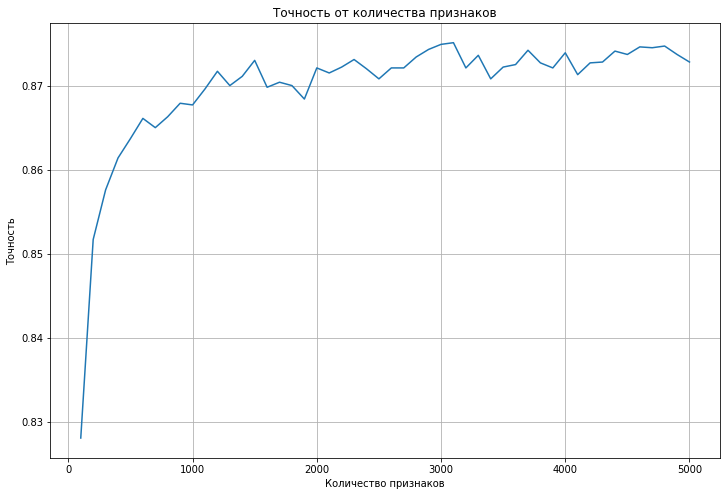

In [0]:
fig = plt.figure(figsize=(12, 8))
plt.plot(features[:len(acc)], acc)
plt.title("Точность от количества признаков")
plt.xlabel("Количество признаков")
plt.ylabel("Точность")
plt.grid()
plt.show()

*Вывод 2:* при увеличении количества признаков $ <3000$ наблюдается повышении  точности предсказания модели, затем функционал качества выходит на плато.

### Бонус

Ниже приведены задания на бонусные баллы. За исследования на стандартных датасетах из sklearn или, скажем, на титанике, баллы не будут начисляться. Приветствуются интересные выводы из проведённых экспериментов.

__Задание 4. (Максимум 2 балла)__

Возьмите какой-нибудь достаточно сложный датасет, на котором хорошо работает градиентный бустинг. Сравните бустинг с нашим алгоритмом со случайными признаками с точки зрения качества и скорости. Подберите как следует гиперпараметры алгоритма.


Датасет для исследования состоит из  числовых характеристик голосовых сэмплов, по которым необходимо определить пол говорящего.

In [0]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [0]:
data = pd.read_csv('drive/My Drive/voice.csv')

In [30]:
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [0]:
sc = StandardScaler()
lc = LabelEncoder()
x = sc.fit_transform(data.drop('label', axis = 1))
y = lc.fit_transform(data.label)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=241)

In [40]:
n_trees = [1, 10, 100, 300, 500,  700]
learning_rate = np.logspace(-5, 0, 6)
learning_rate = list(learning_rate)
param = {'n_estimators':n_trees, 'learning_rate':learning_rate}

clf = LGBMClassifier()
kf = KFold(n_splits=3)
cv = kf.split(X_train)
search = GridSearchCV(clf, param, cv = cv, n_jobs = 2)
search.fit(X_train, y_train)  
print(search.best_params_)

{'learning_rate': 0.1, 'n_estimators': 100}


In [51]:
model = LGBMClassifier(n_estimators = 100 , learning_rate = 0.1)
start = time()
model.fit(X_train, y_train)
print(time() - start)
np.mean(y_test == model.predict(X_test))

0.19013714790344238


0.9789695057833859

In [52]:
model = Classifier(model = LogisticRegression, n_features =50, new_dim = 5, median_size = 100000)
model.fit(X_train, y_train)
np.mean(y_test == model.predict(X_test))

0.0707404613494873


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9232386961093586

*Вывод:* на выбранном датасете обе модели работают быстро и с высокой точностью, однако по качеству градиентный бустинг лучше на 5%.

__Задание 5. (Максимум 2 балла)__

Возьмите какой-нибудь датасет с текстами и решите одним из стандартных методов (например, tf-idf + логистическая регрессия или что-то нейросетевое). Сравните по качеству и скорости с нашим алгоритмом.

Для работы взяд датасет, состоящий из текстов новостей BBC, разделенных по 5 категориям: спорт, политика, технологии, развлечения, бизнес. https://www.kaggle.com/yufengdev/bbc-fulltext-and-category

In [0]:
import pandas as pd

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
data  = pd.read_csv('drive/My Drive/bbc-text.csv')
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
data['text'] = data['text'].str.lower()
nums = '0123456789'
data['text'] = data['text'].apply(lambda s: str(s).translate(str.maketrans('', '', string.punctuation)))
data['text'] = data['text'].apply(lambda s: str(s).translate(str.maketrans('', '', nums)))
words = stopwords.words("english")
data['text'] = data['text'].apply(lambda x: " ".join([i for i in x.split() if i not in words]))

In [18]:
data.head()

,category,text
0,tech,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldcom...
2,sport,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle fa cup premiership side...
4,entertainment,ocean twelve raids box office ocean twelve cri...


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [0]:
vectorizer = TfidfVectorizer()
m = vectorizer.fit_transform(data['text'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(m, data[['category']],
                                                    test_size=0.3)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

In [0]:
X_train.shape

(1557, 30174)

In [25]:
clf = LogisticRegression()
start = time()
clf.fit(X_train, y_train)
end = time()
print(end - start)
res = clf.predict(X_test)
np.mean(y_test == res)

1.495551586151123


0.9790419161676647

In [27]:
model = Classifier(model = LogisticRegression, n_features =10000, new_dim = 800)
model.fit(X_train.toarray(), y_train)
model.accuracy(X_test.toarray(), y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


4.907518148422241


0.9730538922155688

*Вывод:* при хорошо подобранных параметрах наша модель классификации, использующая логистическую регрессию, PCA и новые признаки, достигает почти такого же качества, как и градиентный бустинг, однако оказывается медленнее по скорости работы.

__Задание 6. (Максимум 2 балла)__

Поэкспериментируйте на нескольких датасетах из прошлых пунктов с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества.